# Table of Contents
* [Function to log results](#Function-to-log-results)
* [Import data and Recover the 5-Fold Validation Indices](#Import-data-and-Recover-the-5-Fold-Validation-Indices)
* [Word2Vec Embeddings](#Word2Vec-Embeddings)
* [Classification Models](#Classification-Models)
    * [1.1 RandomForest](#1.1-RandomForest)
    * [1.2 LightGBM](#1.2-LightGBM)
    * [1.3 Logistic Regression with regularizations](#1.3-Logistic-Regression-with-regularizations)
* [Summary of models](#Summary-of-models)
* [Assign ID column to prepare for merging with other datasets](#Assign-ID-column-to-prepare-for-merging-with-other-datasets)
* [Appendix Neural Network Model](#Appendix-Neural-Network-Model)
    * [2 hidden layers](#2-hidden-layers)
    * [3 hidden layers](#3-hidden-layers)
    * [2 hidden layers with more nodes](#2-hidden-layers-with-more-nodes)

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
import warnings
warnings.filterwarnings("ignore")

In [3]:
#import sys
#!conda install --yes --prefix {sys.prefix} -c conda-forge lightgbm
#!pip install afinn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow.python.keras import models, layers, optimizers
#import tensorflow
#from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
#from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re
%matplotlib inline
# Training and Testing data files are available in the "../python notebook v1" directory.
# The following function finds all the .csv files in the project directory
import os
#def find_csv_filenames(path_to_dir, suffix=".csv"):
#    filenames = os.listdir(path_to_dir)
#    return [filename for filename in filenames if filename.endswith(suffix)]
#filenames = find_csv_filenames("../python notebook v1")
#for name in filenames:
#    print(name)

pd.options.display.max_colwidth = 200
import statistics
from scipy import stats
from scipy.stats import t
from scipy.stats import norm
import seaborn as sns
import sklearn
import sqlite3
from sqlite3 import Error
import csv
import lightgbm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Function to log results

In [4]:
def model_log(cv_clf, modelname):
    rlt_dict = {}

    rlt_dict['best_estimator_'] = [cv_clf.best_estimator_]
    rlt_dict['best_params_'] = [cv_clf.best_params_]
    rlt_dict['best_score_'] = [cv_clf.best_score_]
    rlt_dict['best_index_'] = [cv_clf.best_index_]

    rlt_dict['candidate_params'] = [cv_clf.cv_results_['params']]
    rlt_dict['mean_test_score'] = [cv_clf.cv_results_['mean_test_score']]
    rlt_dict['std_test_score'] = [cv_clf.cv_results_['std_test_score']]
    rlt_dict['mean_train_score'] = [cv_clf.cv_results_['mean_train_score']]
    rlt_dict['std_train_score'] = [cv_clf.cv_results_['std_train_score']]

    rlt_dict['split0_test_score'] = [cv_clf.cv_results_['split0_test_score']]
    rlt_dict['split1_test_score'] = [cv_clf.cv_results_['split1_test_score']]
    rlt_dict['split2_test_score'] = [cv_clf.cv_results_['split2_test_score']]
    rlt_dict['split3_test_score'] = [cv_clf.cv_results_['split3_test_score']]
    rlt_dict['split4_test_score'] = [cv_clf.cv_results_['split4_test_score']]

    rlt_dict['split0_train_score'] = [cv_clf.cv_results_['split0_train_score']]
    rlt_dict['split1_train_score'] = [cv_clf.cv_results_['split1_train_score']]
    rlt_dict['split2_train_score'] = [cv_clf.cv_results_['split2_train_score']]
    rlt_dict['split3_train_score'] = [cv_clf.cv_results_['split3_train_score']]
    rlt_dict['split4_train_score'] = [cv_clf.cv_results_['split4_train_score']]

    rlt_df = pd.DataFrame.from_dict(rlt_dict)
    
    filename = modelname + '_' + 'cv_rlt.csv'
    rlt_df.to_csv(filename)

## Import data and Recover the 5-Fold Validation Indices

In [5]:
X_train = pd.read_csv("X_train.csv", )
y_train_0 = pd.read_csv("y_train.csv", header=None)
y_train = y_train_0[0]
X_test = pd.read_csv("X_test.csv", )
y_test_0 = pd.read_csv("y_test.csv", header=None)
y_test = y_test_0[0]

In [6]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (11640, 9)
y_train shape:  (11640,)
X_test shape:  (2911, 9)
y_test shape:  (2911,)


In [7]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=123, shuffle=True)
kf.get_n_splits(X_train)

5

In [8]:
i = 1
for train_index, val_index in kf.split(X_train):
    print(f"Fold {i}: ", "Train:", train_index, "Validation:", val_index)
    i = i + 1

Fold 1:  Train: [    0     1     2 ... 11636 11638 11639] Validation: [    3     6     7 ... 11619 11620 11637]
Fold 2:  Train: [    1     3     5 ... 11637 11638 11639] Validation: [    0     2     4 ... 11591 11624 11629]
Fold 3:  Train: [    0     1     2 ... 11637 11638 11639] Validation: [    8    33    35 ... 11631 11635 11636]
Fold 4:  Train: [    0     2     3 ... 11636 11637 11638] Validation: [    1     5    18 ... 11632 11634 11639]
Fold 5:  Train: [    0     1     2 ... 11636 11637 11639] Validation: [   13    16    17 ... 11628 11633 11638]


## Word2Vec Embeddings

In [9]:
from nltk.tokenize import word_tokenize
token_text_train = []
for t in X_train.text:
    token_text_train.append(word_tokenize(t))
print(token_text_train[:2])

token_text_test = []
for t in X_test.text:
    token_text_test.append(word_tokenize(t))
print(token_text_test[:2])

[['point', 'u', 'cancel', 'flight', 'flight', 'dca', 'airline', 'already', 'cancel', 'flightle'], ['submit', 'response', 'link', 'send']]
[['yes', 'take', 'two', 'day', 'get', 'bag', 'deliver', 'miss', 'full', 'day', 'skiing'], ['would', 'fly', 'airline', 'actually', 'give', 'crap', 'flier', 'outside', 'generic', 'apology', 'jet', 'blue', 'terrible']]


In [10]:
from gensim.models import Word2Vec
sentences = token_text_train
model = Word2Vec(sentences, min_count=1, size=100, workers=3, window=3, sg=1)
model['point']

array([-0.07969166, -0.13359378, -0.06282508,  0.01713425, -0.17109342,
        0.3710323 , -0.10559011, -0.33518222, -0.03893487,  0.3210081 ,
       -0.13439968, -0.11388889, -0.2771691 , -0.1334348 ,  0.00568711,
       -0.28211975,  0.14367965, -0.01098808,  0.07992469,  0.02051907,
        0.15365668, -0.06151427,  0.05184138,  0.09210832, -0.04540148,
       -0.10569192,  0.37084153,  0.20984976,  0.13007884,  0.08138811,
       -0.02335849,  0.23138835, -0.10772855, -0.15329947, -0.03943898,
       -0.04400023,  0.2724749 ,  0.05353895, -0.18415712,  0.04487668,
        0.10497601, -0.26177943,  0.13738775,  0.2557617 , -0.08450399,
       -0.1258028 ,  0.09023808, -0.10918764,  0.04676205,  0.0440051 ,
        0.04311101, -0.21648487,  0.05951409,  0.03516252,  0.08925147,
        0.07213113,  0.07786454, -0.19244693, -0.09314907, -0.08922146,
       -0.21694201,  0.00446629, -0.50172275,  0.09796652,  0.00733995,
       -0.05047787, -0.25997037, -0.19093569, -0.08836737,  0.07

Average out the word embeddings for each word in a review (row).

In [11]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

In [12]:
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                for tokenized_sentence in corpus]
    return np.array(features)

In [13]:
# get row level embeddings
feature_size = 100
feature_array = averaged_word_vectorizer(corpus=sentences, model=model, num_features=feature_size)
wv_features = pd.DataFrame(feature_array)

name = []
for i in range(1,101):
    name.append('feature_' + str(i))
    
wv_features.columns = name
#wv_features.head()

## Classification Models

### 1.1 RandomForest

In [13]:
import time
start = time.process_time()

niter, verbose, random_state = [5, 0, 123] 
param_space = {'n_estimators': range(100,500,100), 'max_depth': range(1,10)}

clf = RandomForestClassifier(random_state=random_state)
cv_clf = RandomizedSearchCV(clf, param_space, cv=kf, n_iter=niter, return_train_score=True, 
                            verbose=verbose, n_jobs=-1) 
cv_clf.fit(wv_features, y_train)

print('completed in {} s'.format(time.process_time() - start))

# write out results
model_log(cv_clf, 'w2v_rf')

completed in 53.19143199999999 s


In [14]:
import re
import ast
result = pd.read_csv('w2v_rf_cv_rlt.csv')
candidate_params = ast.literal_eval(result.candidate_params.values[0])
print("1. Five candidate parameters are: ", candidate_params)
best_n = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['n_estimators']
best_d = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['max_depth']
print("2. Best number of trees and depth are: {} and {}".format(best_n, best_d))
best_score_rf = result.best_score_.values[0]
print("3. Best average CV validation score is: ", best_score_rf)
mean_test_score = result.mean_test_score.values[0]
print("4. Average CV validation score: ", mean_test_score)
std_test_score = result.std_test_score.values[0]
print("5. Standard Deviation of CV validation score: ", std_test_score)
mean_train_score = result.mean_train_score.values[0]
print("6. Average CV training score: ", mean_train_score)
std_train_score = result.std_train_score.values[0]
print("7. Standard Deviation of CV training score: ", std_train_score)

print("1st fold validation score: ", result.split0_test_score.values[0])
print("2nd fold validation score: ", result.split1_test_score.values[0])
print("3rd fold validation score: ", result.split2_test_score.values[0])
print("4th fold validation score: ", result.split3_test_score.values[0])
print("5th fold validation score: ", result.split4_test_score.values[0])
print("1st fold training score: ", result.split0_train_score.values[0])
print("2nd fold training score: ", result.split1_train_score.values[0])
print("3rd fold training score: ", result.split2_train_score.values[0])
print("4th fold training score: ", result.split3_train_score.values[0])
print("5th fold training score: ", result.split4_train_score.values[0])

1. Five candidate parameters are:  [{'n_estimators': 300, 'max_depth': 8}, {'n_estimators': 200, 'max_depth': 5}, {'n_estimators': 200, 'max_depth': 8}, {'n_estimators': 400, 'max_depth': 1}, {'n_estimators': 400, 'max_depth': 9}]
2. Best number of trees and depth are: 400 and 9
3. Best average CV validation score is:  0.7060137457044674
4. Average CV validation score:  [0.70223368 0.68823024 0.70197595 0.62989691 0.70601375]
5. Standard Deviation of CV validation score:  [0.00713834 0.00450028 0.00738732 0.00673509 0.00635739]
6. Average CV training score:  [0.76273625 0.70189003 0.76273625 0.62989691 0.792311  ]
7. Standard Deviation of CV training score:  [0.00216019 0.00204094 0.00208853 0.00168377 0.00286467]
1st fold validation score:  [0.71262887 0.69372852 0.71262887 0.62843643 0.7169244 ]
2nd fold validation score:  [0.69974227 0.68943299 0.70231959 0.62800687 0.70360825]
3rd fold validation score:  [0.70747423 0.69201031 0.70704467 0.63960481 0.70833333]
4th fold validation s

Classification performance on the entire training set, shows slight overfitting

In [15]:
result = pd.read_csv('w2v_rf_cv_rlt.csv')
best_n = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['n_estimators']
best_d = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['max_depth']

clf = RandomForestClassifier(n_estimators = best_n, max_depth = best_d, 
                             bootstrap=True, class_weight=None, criterion='gini',
                             max_features='auto', max_leaf_nodes=None,
                             min_impurity_decrease=0.0, min_impurity_split=None,
                             min_samples_leaf=1, min_samples_split=2,
                             min_weight_fraction_leaf=0.0, n_jobs=None,
                             oob_score=False, random_state=123, verbose=0, warm_start=False)

clf.fit(wv_features, y_train)

preds = clf.predict(wv_features)
probs = clf.predict_proba(wv_features)
confusion_matrix = sklearn.metrics.confusion_matrix(y_train, preds, labels=None, sample_weight=None)
report = classification_report(y_train, preds)
accuracy = float(np.sum(preds==y_train))/y_train.shape[0] 

print("1. Confusion Matrix for the training data is: \n", confusion_matrix)
print("2. Training accuracy: %f" % (accuracy))
print("3. Training report: ", report)

1. Confusion Matrix for the training data is: 
 [[1106   72 1263]
 [ 127  825  915]
 [ 155   29 7148]]
2. Training accuracy: 0.779983
3. Training report:                precision    recall  f1-score   support

           0       0.80      0.45      0.58      2441
           1       0.89      0.44      0.59      1867
           2       0.77      0.97      0.86      7332

   micro avg       0.78      0.78      0.78     11640
   macro avg       0.82      0.62      0.68     11640
weighted avg       0.79      0.78      0.76     11640



### 1.2 LightGBM

In [16]:
import time
start = time.process_time()

niter, verbose, random_state = [5, 0, 123] 
param_space = {'n_estimators': range(100,500,100), 'learning_rate': [0.01,0.1,0.5], 
               'max_depth': range(1,5)}

clf = LGBMClassifier(colsample_bytree=1, subsample=1, reg_alpha=0, reg_lambda=1, verbose=verbose,
                     random_state=random_state)
cv_clf = RandomizedSearchCV(clf, param_space, cv=kf, n_iter=niter, return_train_score=True, scoring='accuracy', 
                            verbose=verbose, n_jobs = -1)  
cv_clf.fit(wv_features, y_train)

print('completed in {} s'.format(time.process_time() - start))

# write out results
model_log(cv_clf, 'w2v_GBM')

completed in 16.129211999999995 s


In [17]:
import re
import ast
result = pd.read_csv('w2v_GBM_cv_rlt.csv')
candidate_params = ast.literal_eval(result.candidate_params.values[0])
print("1. Five candidate parameters are: ", candidate_params)
best_n = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['n_estimators']
best_d = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['max_depth']
best_lr = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['learning_rate']
print("2. Best number of trees, learning rate and depth are: {}, {} and {}".format(best_n, best_lr, best_d))
best_score_LGB = result.best_score_.values[0]
print("3. Best average CV validation score is: ", best_score_LGB)
mean_test_score = result.mean_test_score.values[0]
print("4. Average CV validation score: ", mean_test_score)
std_test_score = result.std_test_score.values[0]
print("5. Standard Deviation of CV validation score: ", std_test_score)
mean_train_score = result.mean_train_score.values[0]
print("6. Average CV training score: ", mean_train_score)
std_train_score = result.std_train_score.values[0]
print("7. Standard Deviation of CV training score: ", std_train_score)

print("1st fold validation score: ", result.split0_test_score.values[0])
print("2nd fold validation score: ", result.split1_test_score.values[0])
print("3rd fold validation score: ", result.split2_test_score.values[0])
print("4th fold validation score: ", result.split3_test_score.values[0])
print("5th fold validation score: ", result.split4_test_score.values[0])
print("1st fold training score: ", result.split0_train_score.values[0])
print("2nd fold training score: ", result.split1_train_score.values[0])
print("3rd fold training score: ", result.split2_train_score.values[0])
print("4th fold training score: ", result.split3_train_score.values[0])
print("5th fold training score: ", result.split4_train_score.values[0])

1. Five candidate parameters are:  [{'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.1}, {'n_estimators': 400, 'max_depth': 2, 'learning_rate': 0.5}, {'n_estimators': 300, 'max_depth': 1, 'learning_rate': 0.1}, {'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.1}, {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.5}]
2. Best number of trees, learning rate and depth are: 300, 0.1 and 2
3. Best average CV validation score is:  0.7082474226804124
4. Average CV validation score:  [0.70635739 0.70721649 0.70128866 0.70824742 0.7056701 ]
5. Standard Deviation of CV validation score:  [0.00659669 0.00616884 0.00495459 0.0032646  0.01035713]
6. Average CV training score:  [0.73142182 0.87815722 0.71189863 0.74293385 0.99123711]
7. Standard Deviation of CV training score:  [0.00212943 0.00234156 0.00215356 0.00167663 0.00035681]
1st fold validation score:  [0.7169244  0.70446735 0.70661512 0.71305842 0.68986254]
2nd fold validation score:  [0.71005155 0.7169244  0.69974227

Classification performance on the entire training set, shows slight overfitting

In [18]:
result = pd.read_csv('w2v_GBM_cv_rlt.csv')
best_n = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['n_estimators']
best_d = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['max_depth']
best_lr = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['learning_rate']

clf = LGBMClassifier(n_estimators=best_n, learning_rate=best_lr, max_depth=best_d, 
                     boosting_type='gbdt', class_weight=None, colsample_bytree=1,
                     importance_type='split', min_child_samples=20, min_child_weight=0.001, 
                     min_split_gain=0.0, n_jobs=-1, num_leaves=31, objective=None, random_state=None, 
                     reg_alpha=0, reg_lambda=1, silent=True, subsample=1, subsample_for_bin=200000, 
                     subsample_freq=0, verbose=0)

clf.fit(wv_features, y_train)

preds = clf.predict(wv_features)
probs = clf.predict_proba(wv_features)
confusion_matrix = sklearn.metrics.confusion_matrix(y_train, preds, labels=None, sample_weight=None)
report = classification_report(y_train, preds)
accuracy = float(np.sum(preds==y_train))/y_train.shape[0] 

print("1. Confusion Matrix for the training data is: \n", confusion_matrix)
print("2. Training accuracy: %f" % (accuracy))
print("3. Training report: ", report)

1. Confusion Matrix for the training data is: 
 [[ 932  156 1353]
 [ 200  778  889]
 [ 313  148 6871]]
2. Training accuracy: 0.737199
3. Training report:                precision    recall  f1-score   support

           0       0.64      0.38      0.48      2441
           1       0.72      0.42      0.53      1867
           2       0.75      0.94      0.84      7332

   micro avg       0.74      0.74      0.74     11640
   macro avg       0.71      0.58      0.61     11640
weighted avg       0.73      0.74      0.71     11640



### 1.3 Logistic Regression with regularizations

In [19]:
import time
start = time.process_time()

niter, verbose, random_state = [5, 0, 123] 
param_space = {'penalty': ['l1','l2'], 'C': [0.005, 0.01, 0.1, 1, 10, 50, 100]}
        
clf = LogisticRegression(random_state=random_state, solver='saga', multi_class='multinomial')
cv_clf = RandomizedSearchCV(clf, param_space, cv=kf, n_iter=niter, return_train_score=True, scoring='accuracy', 
                            verbose=verbose, n_jobs = -1) 
cv_clf.fit(wv_features, y_train)

print('completed in {} s'.format(time.process_time() - start))

# write out results
model_log(cv_clf, 'w2v_logistic')

completed in 9.51227800000001 s


/Users/lisalb168/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [20]:
import re
import ast
result = pd.read_csv('w2v_logistic_cv_rlt.csv')
candidate_params = ast.literal_eval(result.candidate_params.values[0])
print("1. Five candidate parameters are: ", candidate_params)
best_c = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['C']
best_penalty = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['penalty']
print("2. Best C and penalty are: {} and {}".format(best_c, best_penalty))
best_score_Logistic = result.best_score_.values[0]
print("3. Best average CV validation score is: ", best_score_Logistic)
mean_test_score = result.mean_test_score.values[0]
print("4. Average CV validation score: ", mean_test_score)
std_test_score = result.std_test_score.values[0]
print("5. Standard Deviation of CV validation score: ", std_test_score)
mean_train_score = result.mean_train_score.values[0]
print("6. Average CV training score: ", mean_train_score)
std_train_score = result.std_train_score.values[0]
print("7. Standard Deviation of CV training score: ", std_train_score)

print("1st fold validation score: ", result.split0_test_score.values[0])
print("2nd fold validation score: ", result.split1_test_score.values[0])
print("3rd fold validation score: ", result.split2_test_score.values[0])
print("4th fold validation score: ", result.split3_test_score.values[0])
print("5th fold validation score: ", result.split4_test_score.values[0])
print("1st fold training score: ", result.split0_train_score.values[0])
print("2nd fold training score: ", result.split1_train_score.values[0])
print("3rd fold training score: ", result.split2_train_score.values[0])
print("4th fold training score: ", result.split3_train_score.values[0])
print("5th fold training score: ", result.split4_train_score.values[0])

1. Five candidate parameters are:  [{'penalty': 'l2', 'C': 0.01}, {'penalty': 'l2', 'C': 50}, {'penalty': 'l2', 'C': 1}, {'penalty': 'l1', 'C': 0.01}, {'penalty': 'l1', 'C': 10}]
2. Best C and penalty are: 10 and l1
3. Best average CV validation score is:  0.7285223367697594
4. Average CV validation score:  [0.6564433  0.72405498 0.70068729 0.63273196 0.72852234]
5. Standard Deviation of CV validation score:  [0.00613164 0.00544432 0.00610147 0.00819085 0.00733015]
6. Average CV training score:  [0.65627148 0.72719072 0.70193299 0.63348368 0.7310567 ]
7. Standard Deviation of CV training score:  [0.00043701 0.00160667 0.00150129 0.00128687 0.00220353]
1st fold validation score:  [0.65034364 0.72594502 0.70489691 0.63015464 0.72938144]
2nd fold validation score:  [0.65549828 0.72594502 0.69931271 0.63230241 0.73109966]
3rd fold validation score:  [0.66709622 0.73024055 0.70919244 0.64390034 0.73969072]
4th fold validation score:  [0.6507732  0.71391753 0.6911512  0.61941581 0.71735395]


Classification performance on the entire training set

In [21]:
result = pd.read_csv('w2v_logistic_cv_rlt.csv')
best_c = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['C']
best_penalty = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['penalty']

clf = LogisticRegression(C=best_c, class_weight=None, dual=False, fit_intercept=True,
                         intercept_scaling=1, max_iter=100, solver='saga', multi_class='multinomial',
                         n_jobs=None, penalty=best_penalty, random_state=123, 
                         tol=0.0001, verbose=0, warm_start=False)
clf.fit(wv_features, y_train)

preds = clf.predict(wv_features)
probs = clf.predict_proba(wv_features)
confusion_matrix = sklearn.metrics.confusion_matrix(y_train, preds, labels=None, sample_weight=None)
report = classification_report(y_train, preds)
accuracy = float(np.sum(preds==y_train))/y_train.shape[0] 

print("1. Confusion Matrix for the training data is: \n", confusion_matrix)
print("2. Training accuracy: %f" % (accuracy))
print("3. Training report: ", report)

1. Confusion Matrix for the training data is: 
 [[ 844  136 1461]
 [ 237  806  824]
 [ 309  142 6881]]
2. Training accuracy: 0.732904
3. Training report:                precision    recall  f1-score   support

           0       0.61      0.35      0.44      2441
           1       0.74      0.43      0.55      1867
           2       0.75      0.94      0.83      7332

   micro avg       0.73      0.73      0.73     11640
   macro avg       0.70      0.57      0.61     11640
weighted avg       0.72      0.73      0.71     11640



/Users/lisalb168/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Summary of models

The best model selected based on average validation score

In [22]:
result = pd.read_csv('w2v_rf_cv_rlt.csv')
best_score_rf = result.best_score_.values[0]

result = pd.read_csv('w2v_GBM_cv_rlt.csv')
best_score_LGB = result.best_score_.values[0]

result = pd.read_csv('w2v_logistic_cv_rlt.csv')
best_score_Logistic = result.best_score_.values[0]

validation_scores = {'RandomForest': best_score_rf, 'LightGBM': best_score_LGB, 
                     'Logistic Regression': best_score_Logistic}
print(validation_scores)

{'RandomForest': 0.7060137457044674, 'LightGBM': 0.7082474226804124, 'Logistic Regression': 0.7285223367697594}


## Assign ID column to prepare for merging with other datasets

In [23]:
wv_features['ID'] = X_train.ID.to_list()
display(wv_features.head())

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,ID
0,-0.174159,-0.376847,0.225733,0.042696,0.134311,-0.060276,-0.012189,0.332817,0.109808,-0.035154,...,0.006819,-0.125875,0.159198,-0.316078,-0.197206,0.233572,0.221987,-0.244346,-0.137475,7908
1,-0.217392,-0.261179,0.162572,-0.014102,0.105449,-0.059530,-0.074041,0.217289,0.127911,-0.280071,...,-0.026931,-0.212833,-0.024392,-0.331016,-0.223917,0.172291,0.092887,-0.018210,-0.151401,538
2,-0.151161,-0.228381,0.137544,-0.004065,0.106829,-0.065577,-0.015647,0.226998,0.102929,-0.170607,...,-0.011838,-0.183797,0.032689,-0.261934,-0.173341,0.207240,0.130469,-0.038150,-0.132023,4501
3,-0.168207,-0.293769,0.148806,0.054308,0.196257,-0.059498,0.059665,0.317779,0.076680,-0.101811,...,-0.047585,-0.187783,0.085278,-0.292194,-0.156288,0.231119,0.220019,-0.126156,-0.098265,13982
4,-0.115914,-0.154277,0.052429,0.038035,0.218828,-0.015134,-0.059788,0.259140,0.187588,-0.194972,...,-0.096516,-0.245784,-0.089559,-0.378685,-0.212268,0.275687,0.117452,-0.141598,-0.191248,6048


In [24]:
wv_features.to_csv("wv_features.csv", index=False)
wv = pd.read_csv("wv_features.csv")
display(wv.head())
print(wv.shape)

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,ID
0,-0.174159,-0.376847,0.225733,0.042696,0.134311,-0.060276,-0.012189,0.332817,0.109808,-0.035154,...,0.006819,-0.125875,0.159198,-0.316078,-0.197206,0.233572,0.221987,-0.244346,-0.137475,7908
1,-0.217392,-0.261179,0.162572,-0.014102,0.105449,-0.059530,-0.074041,0.217289,0.127911,-0.280071,...,-0.026931,-0.212833,-0.024392,-0.331016,-0.223917,0.172291,0.092887,-0.018210,-0.151401,538
2,-0.151161,-0.228381,0.137544,-0.004065,0.106829,-0.065577,-0.015647,0.226998,0.102929,-0.170607,...,-0.011838,-0.183797,0.032689,-0.261934,-0.173341,0.207240,0.130469,-0.038150,-0.132023,4501
3,-0.168207,-0.293769,0.148806,0.054308,0.196257,-0.059498,0.059665,0.317779,0.076680,-0.101811,...,-0.047585,-0.187783,0.085278,-0.292194,-0.156288,0.231119,0.220019,-0.126156,-0.098265,13982
4,-0.115914,-0.154277,0.052429,0.038035,0.218828,-0.015134,-0.059788,0.259140,0.187588,-0.194972,...,-0.096516,-0.245784,-0.089559,-0.378685,-0.212268,0.275687,0.117452,-0.141598,-0.191248,6048


(11640, 101)


## Appendix Neural Network Model

In [14]:
wv_features = pd.read_csv("wv_features.csv")

In [15]:
# Change pandas dataframe to numpy array to satisfy format requirement to train NN
X = wv_features.iloc[:,:100].values
y = y_train.values
y = y.reshape(-1, 1)
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

### 2 hidden layers

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(10, input_dim=100, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 18        
Total params: 1,083
Trainable params: 1,083
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(X, y, epochs=1000, validation_split=0.2, batch_size=100, verbose=0)

With 1000 epochs, the model is still not showing overfitting

In [19]:
print("Validation accuracy: ",history.history['val_accuracy'][999])
print("Training accuracy: ",history.history['accuracy'][999])

Validation accuracy:  0.730240523815155
Training accuracy:  0.74130154


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


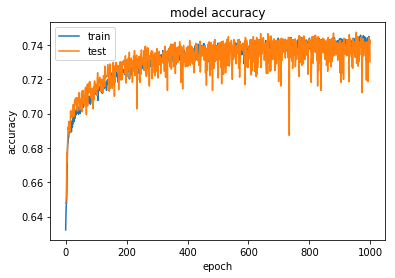

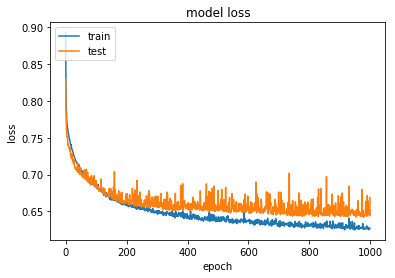

In [20]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
display("Min, Max, Mean, Std of validation accuracy are: ", 
      np.min(history.history['val_accuracy']), 
      np.max(history.history['val_accuracy']), 
      np.mean(history.history['val_accuracy']),
      np.std(history.history['val_accuracy']))

'Min, Max, Mean, Std of validation accuracy are: '

0.6477663516998291

0.7474226951599121

0.7306176977753639

0.01246376166718841

### 3 hidden layers

In [21]:
# add 1 more layer
import keras
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(10, input_dim=100, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 18        
Total params: 1,161
Trainable params: 1,161
Non-trainable params: 0
_________________________________________________________________


In [23]:
history2 = model.fit(X, y, epochs=1000, validation_split=0.2, batch_size=100, verbose=0)

In [24]:
print("Validation accuracy: ",history2.history['val_accuracy'][999])
print("Training accuracy: ",history2.history['accuracy'][999])

Validation accuracy:  0.7401202917098999
Training accuracy:  0.7425902


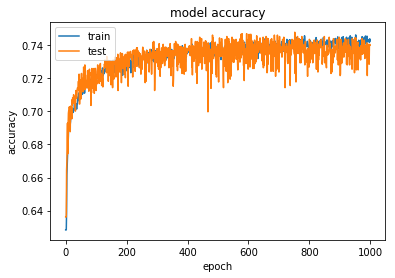

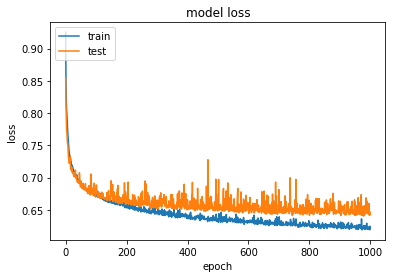

In [25]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
display("Min, Max, Mean, Std of validation accuracy are: ", 
      np.min(history2.history['val_accuracy']), 
      np.max(history2.history['val_accuracy']), 
      np.mean(history2.history['val_accuracy']),
      np.std(history2.history['val_accuracy']))

'Min, Max, Mean, Std of validation accuracy are: '

0.636168360710144

0.7478522062301636

0.7319072166085243

0.011387907023583763

### 2 hidden layers with more nodes

In [26]:
# add more nodes
import keras
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(12, input_dim=100, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 12)                1212      
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 27        
Total params: 1,343
Trainable params: 1,343
Non-trainable params: 0
_________________________________________________________________


In [28]:
history3 = model.fit(X, y, epochs=1000, validation_split=0.2, batch_size=100, verbose=0)

In [29]:
print("Validation accuracy: ",history3.history['val_accuracy'][999])
print("Training accuracy: ",history3.history['accuracy'][999])

Validation accuracy:  0.7366838455200195
Training accuracy:  0.7452749


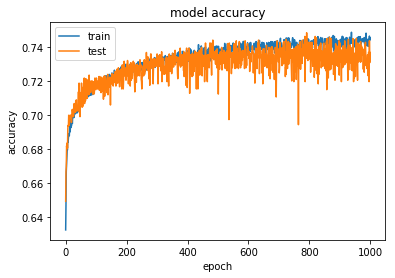

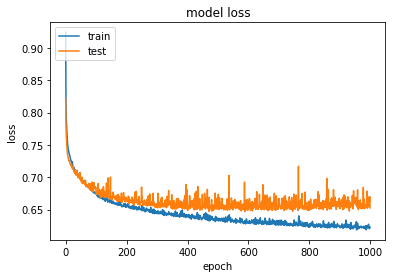

In [30]:
# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
display("Min, Max, Mean, Std of validation accuracy are: ", 
      np.min(history3.history['val_accuracy']), 
      np.max(history3.history['val_accuracy']), 
      np.mean(history3.history['val_accuracy']),
      np.std(history3.history['val_accuracy']))

'Min, Max, Mean, Std of validation accuracy are: '

0.649055004119873

0.7482817769050598

0.7286589344739914

0.010900085652868593